In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from scipy.stats import kendalltau, pearsonr, spearmanr

# Setting up the data

In [10]:
WDI_GFDI_filled = pd.read_excel(r"C:\Users\klyukin\Documents\Python Scripts\phd\_code\research_paper\WDI_GFDI_filled.xlsx")

WDI_GFDI_china = WDI_GFDI_filled[WDI_GFDI_filled['Country Code'].isin(['CHN'])]
WDI_GFDI_china['Stocks traded, total value (current US$)'] = WDI_GFDI_china['Stocks traded, total value (current US$)'].interpolate(method='linear')
WDI_GFDI_not_china = WDI_GFDI_filled[~WDI_GFDI_filled['Country Code'].isin(['CHN'])]
WDI_GFDI_filled = pd.concat([WDI_GFDI_china, WDI_GFDI_not_china])

C:\Users\klyukin\AppData\Local\Temp\ipykernel_29440\1563190167.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WDI_GFDI_china['Stocks traded, total value (current US$)'] = WDI_GFDI_china['Stocks traded, total value (current US$)'].interpolate(method='linear')


In [11]:
WDI_GFDI_filled_2 = WDI_GFDI_filled[['Country Code', 'Year', 'GDP per capita, PPP (constant 2021 international $)']].copy()
WDI_GFDI_filled_2.Year = WDI_GFDI_filled_2.Year+1

In [12]:
WDI_GFDI_filled_2.rename(columns={'GDP per capita, PPP (constant 2021 international $)': 'GDP per capita, PPP (constant 2021 international $) LAST'
                                 }, inplace=True)

In [13]:
WDI_GFDI_filled = pd.merge(WDI_GFDI_filled, WDI_GFDI_filled_2, how='left', on=['Year', 'Country Code'])

In [14]:
WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'] = WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $)']/WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $) LAST']

In [15]:
WDI_GFDI_filled['Value-traded ratio (%)'] = WDI_GFDI_filled['Stocks traded, total value (current US$)'] / WDI_GFDI_filled['GDP (current US$)'] * 100
WDI_GFDI_filled['Stock market turnover ratio (%)'] = WDI_GFDI_filled['Stocks traded, total value (current US$)'] / WDI_GFDI_filled['Market capitalization of listed domestic companies (current US$)'] * 100
WDI_GFDI_filled['Value-traded ratio to stock price volatility'] = WDI_GFDI_filled['Value-traded ratio (%)'] / WDI_GFDI_filled['Stock price volatility']
WDI_GFDI_filled['Market capitalization to GDP'] = WDI_GFDI_filled['Market capitalization of listed domestic companies (current US$)'] / WDI_GFDI_filled['GDP (current US$)'] * 100

WDI_GFDI_filled = WDI_GFDI_filled[WDI_GFDI_filled['Year'].between(1996, 2020)]

# country_names = pd.read_excel(r"C:\Users\klyukin\Documents\Python Scripts\phd\_code\research_paper\research_countries.xlsx")
# WDI_GFDI_filled = pd.merge(WDI_GFDI_filled, country_names, how='left', on='Country Code')

WDI_GFDI_filled = WDI_GFDI_filled[['Country Name', 'Country Code', 'Year', 'Bank deposits to GDP (%)',
                                   'Broad money (% of GDP)', 'Central bank assets to GDP (%)',
                                   'Domestic credit to private sector (% of GDP)',
                                   'Financial system deposits to GDP (%)', 'GDP (current LCU)',
                                   'GDP (current US$)', 'GDP per capita (current LCU)',
                                   'GDP per capita, PPP (constant 2021 international $)',
                                   'Market capitalization of listed domestic companies (current US$)',
                                   'Stock price volatility', 'Stocks traded, total value (current US$)',
                                   'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)',
                                   'GDP, PPP (current international $)',
                                   'Value-traded ratio (%)', 'Stock market turnover ratio (%)',
                                   'Value-traded ratio to stock price volatility',
                                   'Market capitalization to GDP']]

# creating a weighted average funciton
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()

#K means Clustering algorothim function
def doKmeans(X, nclust):
    model = KMeans(nclust, max_iter=1000)
    model.fit(X)
    clust = model.predict(X)
    cent = model.cluster_centers_
    ss = model.inertia_
    features = model.n_features_in_
    return (clust, cent, ss)

In [19]:
WDI_GFDI_filled['Country Name'].unique()

array(['China', 'Brazil', 'Germany', 'Hong Kong SAR, China', 'Indonesia',
       'India', 'Israel', 'Japan', 'Korea, Rep.', 'Malaysia',
       'Philippines', 'Russian Federation', 'Singapore', 'Thailand',
       'Turkiye', 'United States', 'South Africa'], dtype=object)

C:\Users\klyukin\AppData\Local\Temp\ipykernel_29440\2497896003.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





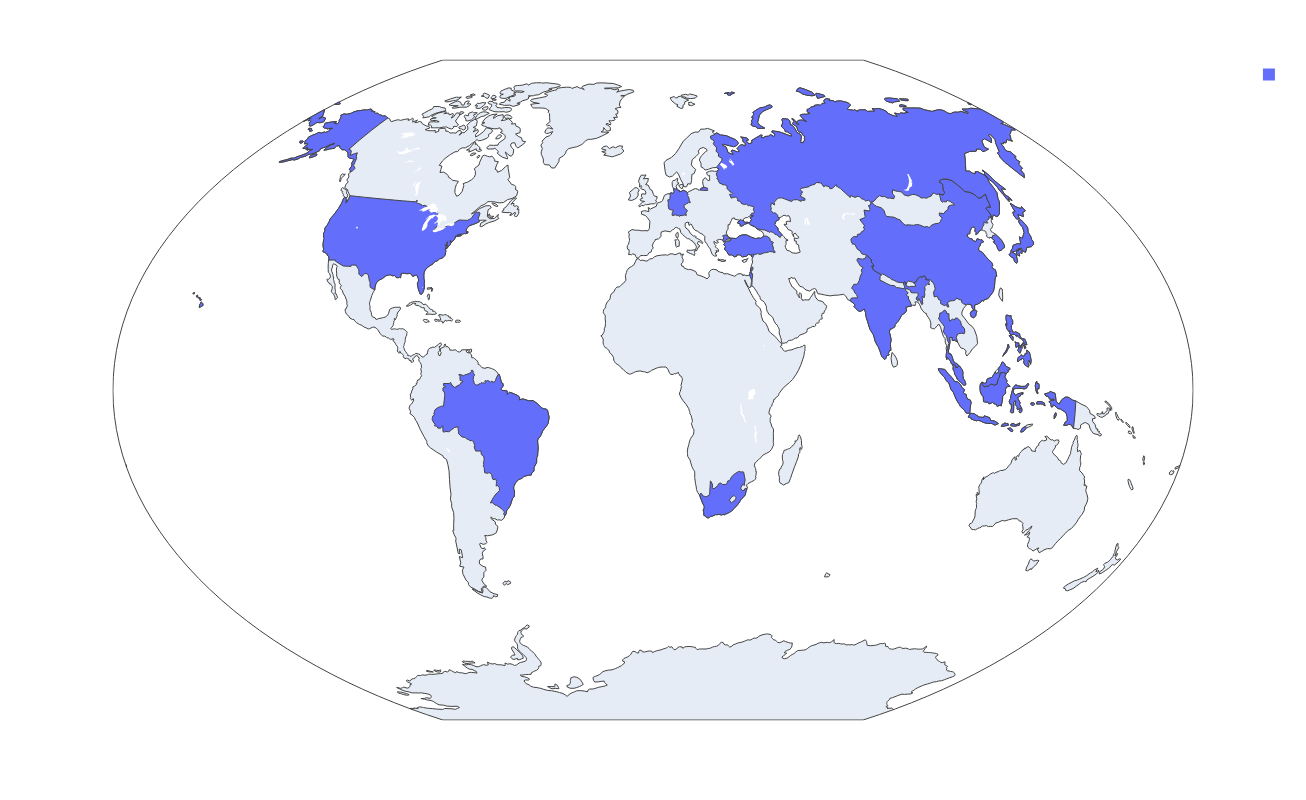

In [22]:
# Create a choropleth map
WDI_GFDI_filled['Country Name'].replace('Turkiye','Turkey',inplace=True)
fig = px.choropleth(WDI_GFDI_filled['Country Name'].unique()
                    , locations=WDI_GFDI_filled['Country Name'].unique()
                    , locationmode='country names'
                    , projection = 'winkel tripel'
                    , width=1400  # Set desired width (in pixels)
                    , height=800   # Set desired height (in pixels)
)

# Show figure
fig.show()

In [ ]:
wh1 = WDI_GFDI_filled[[
    'Stock price volatility'
    , 'Value-traded ratio (%)'
    , 'Stock market turnover ratio (%)'
    , 'Market capitalization to GDP'
    , 'Bank deposits to GDP (%)'
    , 'Broad money (% of GDP)'
    , 'Central bank assets to GDP (%)'
    , 'Domestic credit to private sector (% of GDP)'
    , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
]]

In [24]:
WDI_GFDI_corr_df = WDI_GFDI_filled[['Country Name'
                                    , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
                                    , 'Stock price volatility'
                                    , 'Value-traded ratio (%)'
                                    , 'Stock market turnover ratio (%)'
                                    , 'Market capitalization to GDP'
                                    , 'Bank deposits to GDP (%)'
                                    , 'Broad money (% of GDP)'
                                    , 'Central bank assets to GDP (%)'
                                    , 'Domestic credit to private sector (% of GDP)'                                    
                                   ]]

WDI_GFDI_corr_df.rename(columns={'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)': 'Growth rate'
                                 , 'Stock price volatility': 'Volatility'
                                 , 'Value-traded ratio (%)': 'Value-traded'
                                 , 'Stock market turnover ratio (%)': 'Turnover'
                                 , 'Market capitalization to GDP': 'MarCap to GDP'
                                 , 'Bank deposits to GDP (%)': 'Deposits to GDP'
                                 , 'Broad money (% of GDP)': 'Broad money'
                                 , 'Central bank assets to GDP (%)': 'Central bank assets'
                                 , 'Domestic credit to private sector (% of GDP)': 'Credit to private'                           
                                }, inplace=True)

C:\Users\klyukin\AppData\Local\Temp\ipykernel_29440\3316673946.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# pair plot

In [ ]:
sns.set_theme(style="ticks", font_scale=1.75)

sns.pairplot(WDI_GFDI_corr_df[['Country Name'                               
                               , 'Growth rate'
                               
                               , 'Volatility'
                               , 'Value-traded'
                               , 'Turnover'
                               , 'MarCap to GDP'
                               
                               , 'Deposits to GDP'
                               , 'Broad money'
                               , 'Central bank assets'
                               , 'Credit to private'
                              ]]
             
             # , x_vars=['Volatility'
             #           , 'Value-traded'
             #           , 'Turnover'
             #           , 'MarCap to GDP'
                       
             #           , 'Deposits to GDP'
             #           , 'Broad money'
             #           , 'Central bank assets'
             #           , 'Credit to private'
             #          ]
             # , y_vars=["Growth rate"]
             
             , kind='reg'
             # , palette=sns.color_palette("tab20",n_colors= 17)
             , height=3.25
             , plot_kws={'line_kws': {'linestyle': '--'
                                      , 'linewidth': 1
                                      # , 'alpha': 0.75
                                     }
                         , 'scatter_kws': {'s': 25
                                           , 'alpha': 0.3}
                        }
            )

# correlation

In [ ]:
cor = WDI_GFDI_corr_df.drop(columns=['Country Name'])
cor_value = cor.corr(method='pearson') #Calculate the correlation of the above variables

sns.set_theme(style="ticks", font_scale=0.9)
sns.heatmap(cor_value, annot = True, square = True, vmin=-1, vmax=1, linewidth=.5, fmt=".2f") #Plot the correlation as heat map

In [ ]:
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

cor_p_value = cor.corr(method=pearsonr_pval)
# np.fill_diagonal(cor_p_value.values, 0) # for some reason the diagonal p value for correlation with itself gets equal to 1
sns.heatmap(cor_p_value
            , annot = True
            , square = True
            , vmin=0, vmax=0.1
            , linewidth=.5
            , fmt=".2f", cmap = 'RdYlGn_r') #Plot the correlation as heat map

In [ ]:
# pair plot with countries

In [ ]:
sns.set_theme(style="ticks", font_scale=1.25)

sns.pairplot(WDI_GFDI_corr_df[['Country Name'                               
                               , 'Growth rate'
                               
                               , 'Volatility'
                               , 'Value-traded'
                               , 'Turnover'
                               , 'MarCap to GDP'
                               
                               , 'Deposits to GDP'
                               , 'Broad money'
                               , 'Central bank assets'
                               , 'Credit to private'
                              ]]
             
             # , y_vars=[
             #           # 'Volatility'
             #           # , 'Value-traded'
             #           # , 'Turnover'
             #           # , 'MarCap to GDP'
                       
             #           'Deposits to GDP'
             #           , 'Broad money'
             #           , 'Central bank assets'
             #           , 'Credit to private'
             #          ]
             # , x_vars=["Growth rate"]
             
             , hue="Country Name"
             , palette=sns.color_palette("tab20",n_colors= 17)
             , height=2
             , plot_kws = {'s': 30
                           # , 'alpha': 0.5
                          }
            )

In [25]:
WDI_GFDI_corr_df_log = WDI_GFDI_corr_df.copy()
WDI_GFDI_corr_df_log['Volatility'] = np.log2(WDI_GFDI_corr_df_log['Volatility'])
WDI_GFDI_corr_df_log['Value-traded'] = np.log2(WDI_GFDI_corr_df_log['Value-traded'])
WDI_GFDI_corr_df_log['Turnover'] = np.log2(WDI_GFDI_corr_df_log['Turnover'])
WDI_GFDI_corr_df_log['MarCap to GDP'] = np.log2(WDI_GFDI_corr_df_log['MarCap to GDP'])

WDI_GFDI_corr_df_log['Deposits to GDP'] = np.log2(WDI_GFDI_corr_df_log['Deposits to GDP'])
WDI_GFDI_corr_df_log['Broad money'] = np.log2(WDI_GFDI_corr_df_log['Broad money'])
WDI_GFDI_corr_df_log['Central bank assets'] = np.log2(WDI_GFDI_corr_df_log['Central bank assets'])
WDI_GFDI_corr_df_log['Credit to private'] = np.log2(WDI_GFDI_corr_df_log['Credit to private'])

In [ ]:
# sns.set_theme(style="ticks", font_scale=1.5)

# sns.pairplot(WDI_GFDI_corr_df_log
#              # , hue="Country Name"
#              , kind='reg'

#              # , palette=sns.color_palette("tab20",n_colors= 17)
#              # , markers = ['o', 'v', '^', '8', 's', 'p', 'P', '*', 'h', 'H', 'X', 'D', 'd', '<', '>']
#              , height=2.25
#              # , plot_kws = {'s': 100
#              #               # , 'alpha': 0.75
#              #              }
#              , plot_kws={'line_kws': {'linestyle': '--'
#                                       , 'linewidth': 1
#                                       # , 'alpha': 0.75
#                                      }
#                          , 'scatter_kws': {'s': 5
#                                            , 'alpha': 0.3}}
#                          )

In [ ]:
sns.set_theme(style="ticks", font_scale=1.25)

sns.pairplot(WDI_GFDI_corr_df_log[['Country Name'                               
                               , 'Growth rate'
                               
                               , 'Volatility'
                               , 'Value-traded'
                               , 'Turnover'
                               , 'MarCap to GDP'
                               
                               , 'Deposits to GDP'
                               , 'Broad money'
                               , 'Central bank assets'
                               , 'Credit to private']]
             
             # , y_vars=[
             #           # 'Volatility'
             #           # , 'Value-traded'
             #           # , 'Turnover'
             #           # , 'MarCap to GDP'
                       
             #           'Deposits to GDP'
             #           , 'Broad money'
             #           , 'Central bank assets'
             #           , 'Credit to private'
             #          ]
             # , x_vars=["Growth rate"]
             
             , hue="Country Name"
             , palette=sns.color_palette("tab20",n_colors= 17)
             , height=2
             , plot_kws = {'s': 30
                           # , 'alpha': 0.5
                          }
            )

In [ ]:
# gnuplot
# nipy_spectral
# tab20

sns.color_palette("tab20",n_colors= 17)

# ANOVA

In [ ]:
# https://real-statistics.com/one-way-analysis-of-variance-anova/confidence-interval-anova/

In [ ]:
# https://www.reneshbedre.com/blog/anova.html

# https://www.codecamp.ru/blog/tukey-test-python/

In [27]:
WDI_GFDI_corr_df_log.insert(1,'Year', WDI_GFDI_filled['Year'])

Growth rate


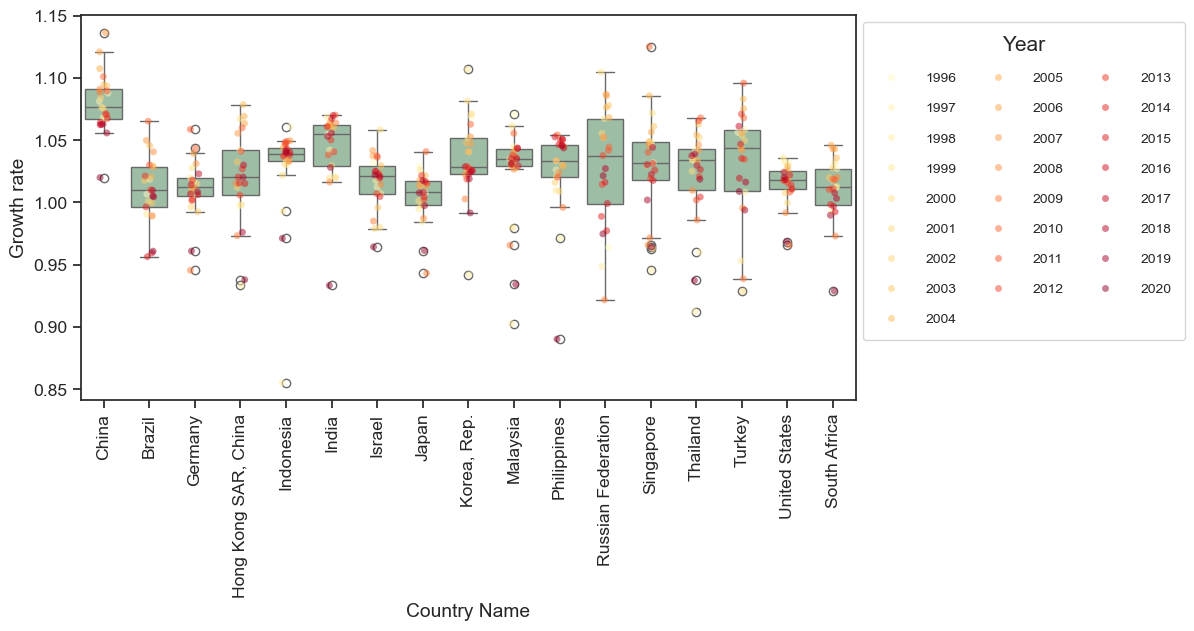

Volatility


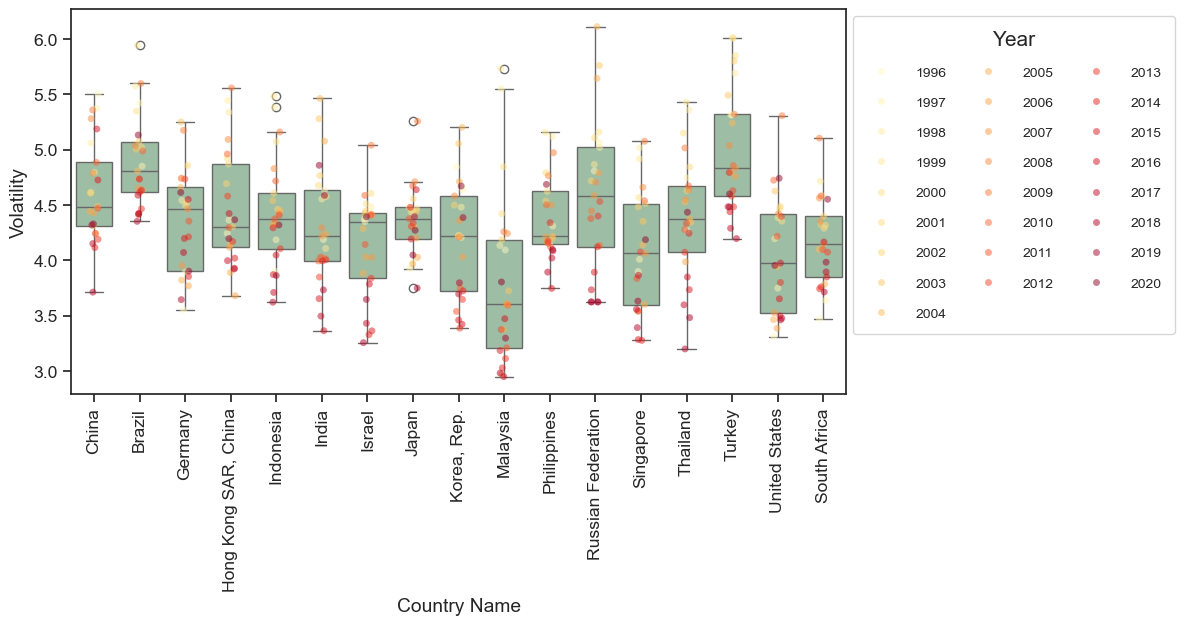

Value-traded


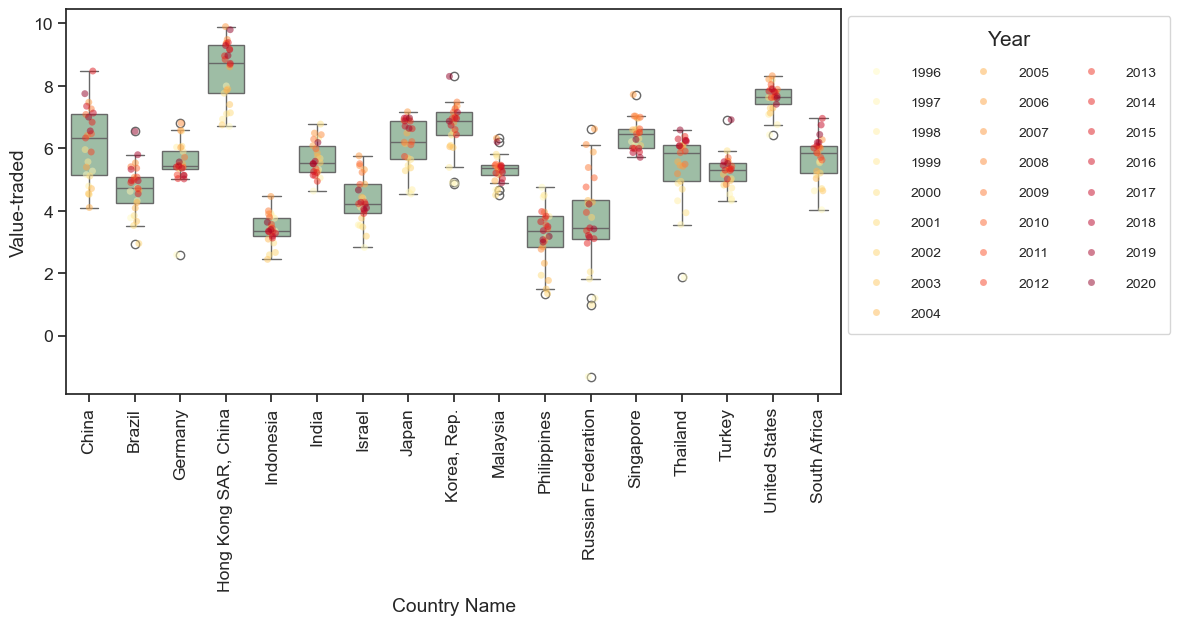

Turnover


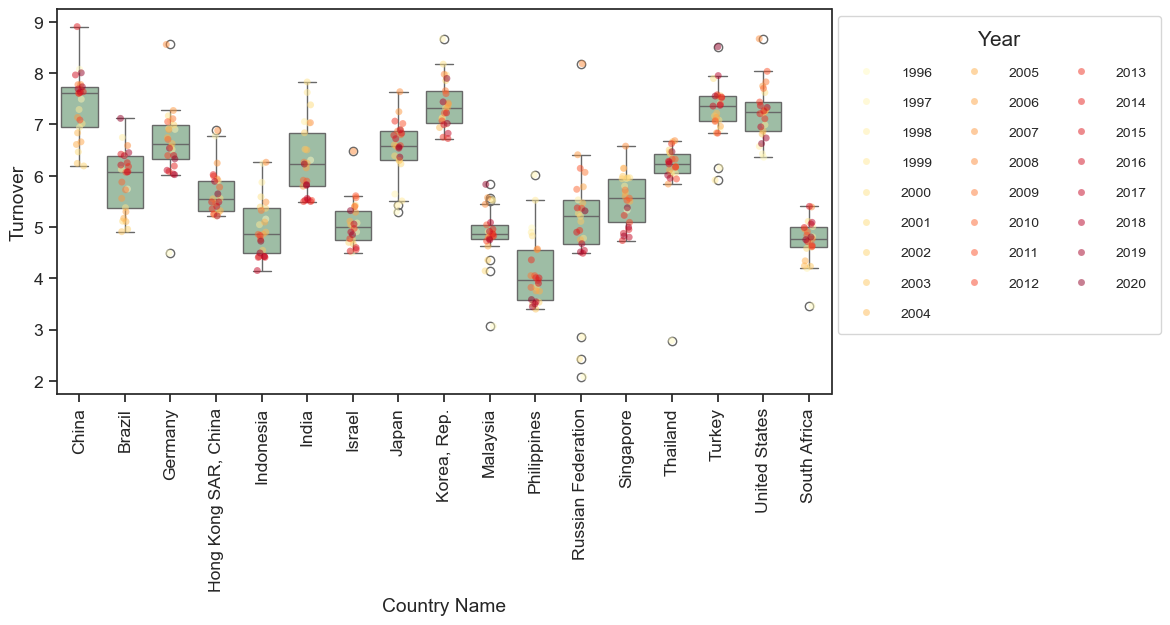

MarCap to GDP


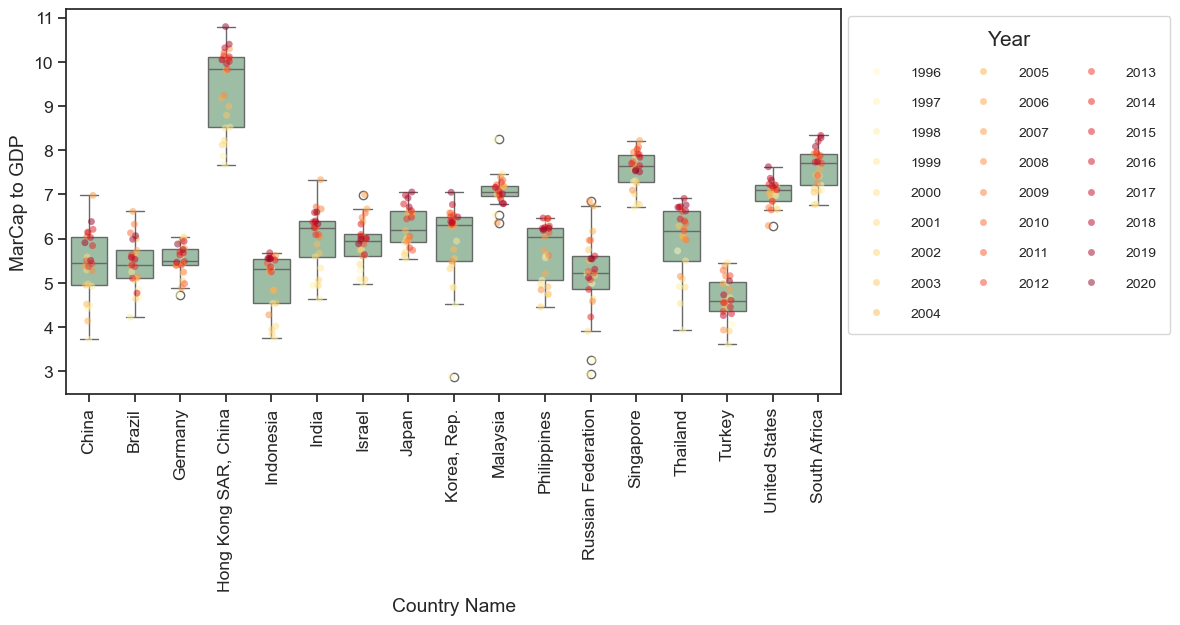

Deposits to GDP


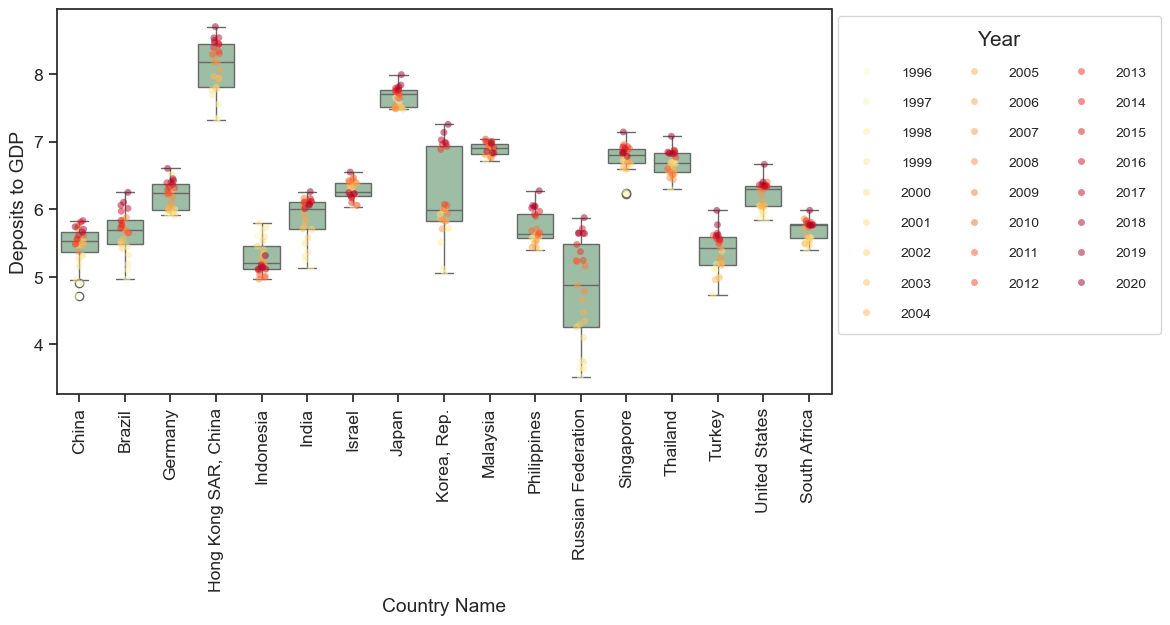

Broad money


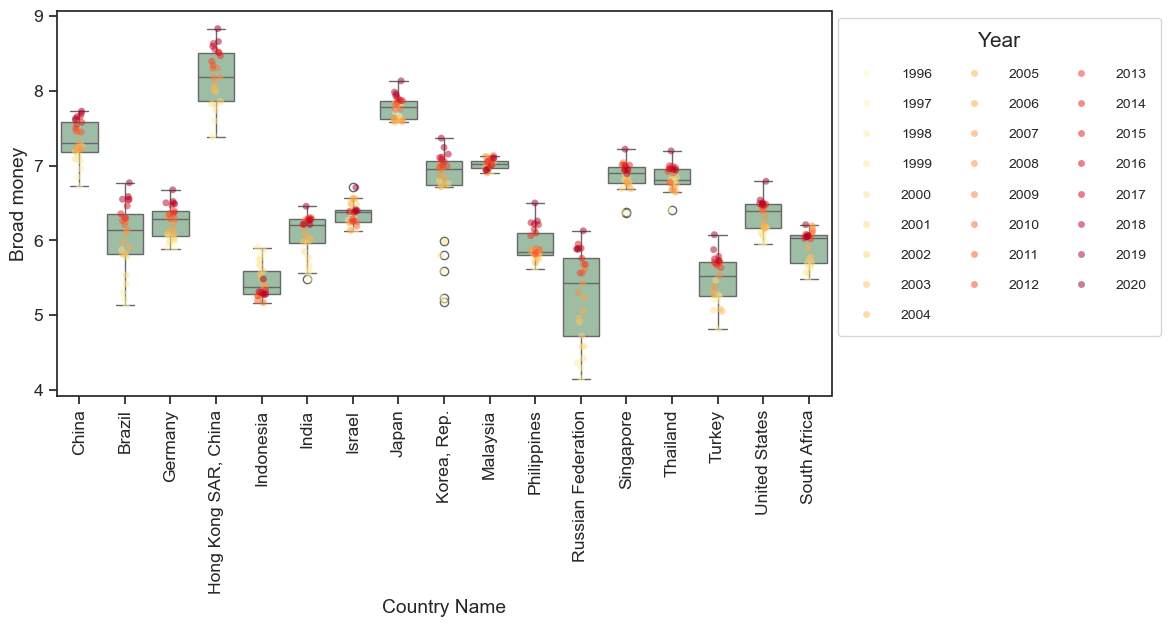

Central bank assets


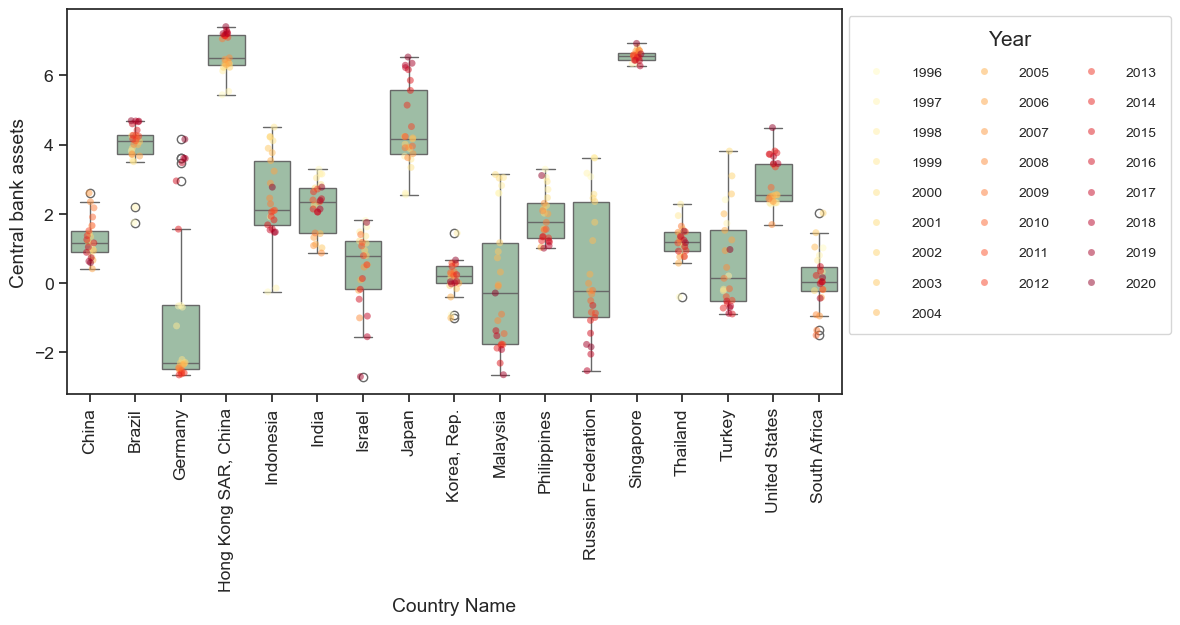

Credit to private


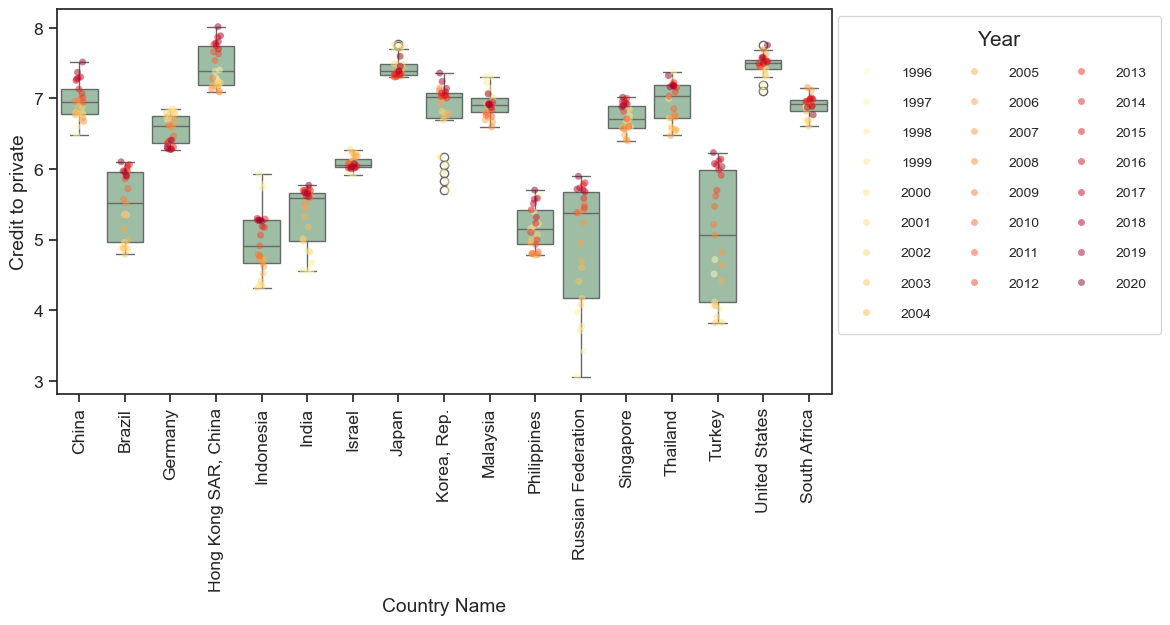

In [33]:
palette = sns.color_palette("YlOrRd", n_colors=len(WDI_GFDI_corr_df_log['Year'].unique()))


for column in WDI_GFDI_corr_df_log.columns[2:]:
    print(column)
    sns.set_theme(style="ticks", font_scale=1.15)
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='Country Name'
                     , y=column
                     , data = WDI_GFDI_corr_df_log
                     , color='#99c2a2'
                    )
    ax = sns.stripplot(x="Country Name" # stripplot # swarmplot
                       , y=column, data = WDI_GFDI_corr_df_log
                       , size=5
                       , hue="Year"
                       , palette=palette
                       , alpha=0.5
                      )
    plt.xticks(rotation=90)  # Rotate x-axis labels
    # plt.yticks(rotation=45)  # Rotate y-axis labels
    
    ax.get_legend().remove()
    
    plt.legend(title='Year'
           , ncols = 3
           , handletextpad=1.5
           , labelspacing=1.25
           , title_fontsize=15
           , borderpad=1
           , fontsize=10
           # , loc="upper left"
           , bbox_to_anchor=(1,1)
          )
    
    plt.show()

In [ ]:
new_WDI_GFDI_corr_df_log = WDI_GFDI_corr_df_log.copy()
new_WDI_GFDI_corr_df_log.rename(columns={'Country Name':'country_name'
                                         , 'Growth rate': 'growth_rate'
                                         
                                         , 'Volatility': 'volatility'
                                         , 'Value-traded': 'value_traded'
                                         , 'Turnover': 'turnover'
                                         , 'MarCap to GDP': 'marcap_to_gdp'
                                         
                                         , 'Deposits to GDP': 'deposits_to_gdp'
                                         , 'Broad money': 'broad_money'
                                         , 'Central bank assets': 'central_bank_assets'
                                         , 'Credit to private': 'credit_to_private'
                                        }, inplace=True)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

master_anova_table = pd.DataFrame()

for column in new_WDI_GFDI_corr_df_log.columns[2:]:
    # print(column)
    model = ols(f'{column} ~ C(country_name)', data=new_WDI_GFDI_corr_df_log).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table.insert(4,'Factor', column)
    master_anova_table = pd.concat([master_anova_table, anova_table])
    # print(anova_table)
    # print('\n')

In [ ]:
# master_anova_table.to_excel(r"anova_analysis_data.xlsx", index=True)

In [ ]:
# https://rpubs.com/shahworld/tukeypython

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

master_tukey_data = pd.DataFrame()

for column in new_WDI_GFDI_corr_df_log.columns[2:]:
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=new_WDI_GFDI_corr_df_log[column],
                              groups=new_WDI_GFDI_corr_df_log['country_name'],
                              alpha= 0.05 )
    tukey_data = pd.DataFrame(data=tukey._results_table.data[1:], columns = tukey._results_table.data[0])
    tukey_data.insert(0,'Factor', column)
    master_tukey_data = pd.concat([master_tukey_data, tukey_data])

In [ ]:
# master_tukey_data.to_excel(r"tukey_analysis_data.xlsx", index=True)

In [ ]:
# Вот как интерпретировать вывод:

# P-значение для разницы в средних значениях между a и b: 0,0158 .
# P-значение для разницы в средних значениях между a и c: 0,8864 .
# P-значение для разницы средних значений между b и c: 0,0453 .

# Таким образом, мы можем заключить, что существует статистически значимая разница между средними значениями групп а и b и групп b и c , но нет статистически значимой разницы между средними значениями групп а и с .

# Stock market relative kmeans

In [ ]:
stock_market_activity_df = pd.DataFrame()
stock_market_clusters_df = pd.DataFrame()

for year in WDI_GFDI_filled['Year'].drop_duplicates():

    # creating a one year df
    WDI_GFDI_year = WDI_GFDI_filled[WDI_GFDI_filled['Year'].isin([year])]
    
    # selecting the stock market activity indicators
    wh1 = WDI_GFDI_year[[
        'Stock price volatility',
        'Value-traded ratio (%)', 
        'Stock market turnover ratio (%)',
        'Market capitalization to GDP'
    ]]

    #calling the function and transforming clusters to a df
    clust, cent, ss = doKmeans(wh1, 7)
    kmeans = pd.DataFrame(clust)
    
    # attaching the kmeans clusters, years and country names
    wh1.insert(0,'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'])
    wh1.insert(0,'GDP, PPP (current international $)', WDI_GFDI_filled['GDP, PPP (current international $)'])
    
    wh1.insert(0,'kmeans', list(kmeans[0]))
    wh1.insert(0,'Year', WDI_GFDI_filled['Year'])
    wh1.insert(0,'Country', WDI_GFDI_filled['Country Name'])
    wh1 = wh1.sort_values(by=['Year'])
    
    # creating and sorting the cluster centroids to provie 
    clusters_df = pd.DataFrame(cent, columns = wh1.columns[5:])
    
    
    clusters_df.insert(0
                       ,'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                       , wh1[['kmeans','GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', 'GDP, PPP (current international $)']].groupby('kmeans').apply(weighted_average
                                                                                                                                                      , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)' # 'value'
                                                                                                                                                      , 'GDP, PPP (current international $)' # 'weight'
                                                                                                                                                     ).values)
    
    clusters_df = clusters_df.sort_values(by=['GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'], ascending=False).reset_index(drop=False)
    cluster_names = ['Ultra high GDP per capita PPP annual growth'
                     , 'High GDP per capita PPP annual growth'
                     , 'Medium-high GDP per capita PPP annual growth'
                     , 'Medium GDP per capita PPP annual growth'
                     , 'Medium-low GDP per capita PPP annual growth'
                     , 'Low GDP per capita PPP annual growth'
                     , 'Ultra low GDP per capita PPP annual growth']
    
    clusters_df.insert(1,'Year', year)
    clusters_df.insert(1,'Сluster names', cluster_names)
    clusters_df.rename(columns={'index': 'kmeans'}, inplace=True)
    clusters_df = clusters_df.reset_index(drop=False)
    clusters_df.insert(1,'Sum of squared distances', ss)
    
    stock_market_clusters_df = pd.concat([stock_market_clusters_df, clusters_df])
    
    cluster_names = clusters_df[['kmeans','index','Сluster names']]
    
    wh1.insert(1,'Sum of squared distances', ss)
    wh1 = pd.merge(wh1, cluster_names, how='left', on='kmeans')
    wh1 = wh1.sort_values(by=['index'], ascending=True)
    
    stock_market_activity_df = pd.concat([stock_market_activity_df, wh1])

# create a group using groupby 
group = stock_market_activity_df[['Country', 'Year', 'Сluster names']].groupby(['Year','Сluster names']) 
  
# count the observations 
country_cluster_count_df = group.count().reset_index(drop = False)

# changing the name
country_cluster_count_df.columns.values[2] = 'Number of members'

# attaching the number of memebers to the df
stock_market_clusters_df = pd.merge(stock_market_clusters_df, country_cluster_count_df, how='left', on=['Year', 'Сluster names'])

In [ ]:
# for year in stock_market_activity_df['Year'].drop_duplicates():

#     # creating a one year df
#     wh1 = stock_market_activity_df[stock_market_activity_df['Year'].isin([year])]
    
#     # Map discrete categories to colors  
#     color_map = {
#         'Ultra high GDP per capita PPP annual growth': "lime"
#         , 'High GDP per capita PPP annual growth': "greenyellow"
#         , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
#         , 'Medium GDP per capita PPP annual growth': "gold"
#         , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
#         , 'Low GDP per capita PPP annual growth': "orangered"
#         , 'Ultra low GDP per capita PPP annual growth': "darkred"
#     }
    
#     # Create a choropleth map
#     fig = px.choropleth(
#         wh1,
#         locations='Country',  # Column with locations
#         locationmode='country names',  # Use country names
#         color='Сluster names',  # Column with categories for colors
#         color_discrete_map=color_map,  # Use your defined color map
#         projection = 'winkel tripel',
#         # scope='asia',
#         width=1400,  # Set desired width (in pixels)
#         height=800   # Set desired height (in pixels)
#     )
    
#     fig.update_layout(title=dict(text=f'''Stock market activity and GDP per capita PPP annual growth in {year}''', font=dict(size=24)))
    
#     # # Show figure
#     fig.show()

In [ ]:
# stock_market_clusters_df.to_excel(r"realtive_stock_market_clusters_df.xlsx", index=False)

# stock_market_activity_df.to_excel(r"realtive_stock_market_df.xlsx", index=False)

## Scatterplot Matrix

In [ ]:
stock_market_activity_df_ = stock_market_activity_df.copy()

df_countries_clusters = stock_market_activity_df_[[

    'Сluster names'

    , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
    
    , 'Stock price volatility'
    , 'Value-traded ratio (%)'
    , 'Stock market turnover ratio (%)'
    , 'Market capitalization to GDP'
    
    # , 'Bank deposits to GDP (%)'
    # , 'Broad money (% of GDP)'
    # , 'Central bank assets to GDP (%)'
    # , 'Domestic credit to private sector (% of GDP)'
       ]]

df_countries_clusters.rename(columns={'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)': 'Growth rate'
                                      , 'Stock price volatility': 'Volatility'
                                      , 'Value-traded ratio (%)': 'Value-traded'
                                      , 'Stock market turnover ratio (%)': 'Turnover'
                                      , 'Market capitalization to GDP': 'MarCap to GDP'
                                      , 'Bank deposits to GDP (%)': 'Deposits to GDP'
                                      , 'Broad money (% of GDP)': 'Broad money'
                                      , 'Central bank assets to GDP (%)': 'Central bank assets'
                                      , 'Domestic credit to private sector (% of GDP)': 'Credit to private'                           
                                     }, inplace=True)

color_dict = {
        'Ultra high GDP per capita PPP annual growth': "lime"
        , 'High GDP per capita PPP annual growth': "greenyellow"
        , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
        , 'Medium GDP per capita PPP annual growth': "gold"
        , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
        , 'Low GDP per capita PPP annual growth': "orangered"
        , 'Ultra low GDP per capita PPP annual growth': "darkred"
    }

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.4325
                          }
            )

In [ ]:
df_countries_clusters_log = df_countries_clusters.copy()
df_countries_clusters_log['Volatility'] = np.log2(df_countries_clusters_log['Volatility'])
df_countries_clusters_log['Value-traded'] = np.log2(df_countries_clusters_log['Value-traded'])
df_countries_clusters_log['Turnover'] = np.log2(df_countries_clusters_log['Turnover'])
df_countries_clusters_log['MarCap to GDP'] = np.log2(df_countries_clusters_log['MarCap to GDP'])

# df_countries_clusters_log['Deposits to GDP'] = np.log2(df_countries_clusters_log['Deposits to GDP'])
# df_countries_clusters_log['Broad money'] = np.log2(df_countries_clusters_log['Broad money'])
# df_countries_clusters_log['Central bank assets'] = np.log2(df_countries_clusters_log['Central bank assets'])
# df_countries_clusters_log['Credit to private'] = np.log2(df_countries_clusters_log['Credit to private'])

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters_log
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.75
                          }
            )

# Banking activity relative kmeans

In [ ]:
# year = 2020
banking_activity_df = pd.DataFrame()
banking_activity_clusters_df = pd.DataFrame()

for year in WDI_GFDI_filled['Year'].drop_duplicates():

    # creating a one year df
    WDI_GFDI_year = WDI_GFDI_filled[WDI_GFDI_filled['Year'].isin([year])]
    
    # selecting the stock market activity indicators
    wh1 = WDI_GFDI_year[[
        'Bank deposits to GDP (%)', 
        'Broad money (% of GDP)',
        'Central bank assets to GDP (%)',
        'Domestic credit to private sector (% of GDP)'
    ]]

    #calling the function and transforming clusters to a df
    clust, cent, ss = doKmeans(wh1, 7)
    kmeans = pd.DataFrame(clust)
    
    # attaching the kmeans clusters, years and country names
    wh1.insert(0,'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'])
    wh1.insert(0,'GDP, PPP (current international $)', WDI_GFDI_filled['GDP, PPP (current international $)'])
    
    wh1.insert(0,'kmeans', list(kmeans[0]))
    wh1.insert(0,'Year', WDI_GFDI_filled['Year'])
    wh1.insert(0,'Country', WDI_GFDI_filled['Country Name'])
    wh1 = wh1.sort_values(by=['Year'])
    
    # creating and sorting the cluster centroids to provie 
    clusters_df = pd.DataFrame(cent, columns = wh1.columns[5:])
    
    
    clusters_df.insert(0
                       ,'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                       , wh1[['kmeans','GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', 'GDP, PPP (current international $)']].groupby('kmeans').apply(weighted_average
                                                                                                                                                      , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)' # 'value'
                                                                                                                                                      , 'GDP, PPP (current international $)' # 'weight'
                                                                                                                                                     ).values)
    
    clusters_df = clusters_df.sort_values(by=['GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'], ascending=False).reset_index(drop=False)
    cluster_names = ['Ultra high GDP per capita PPP annual growth'
                     , 'High GDP per capita PPP annual growth'
                     , 'Medium-high GDP per capita PPP annual growth'
                     , 'Medium GDP per capita PPP annual growth'
                     , 'Medium-low GDP per capita PPP annual growth'
                     , 'Low GDP per capita PPP annual growth'
                     , 'Ultra low GDP per capita PPP annual growth']
    
    clusters_df.insert(1,'Year', year)
    clusters_df.insert(1,'Сluster names', cluster_names)
    clusters_df.rename(columns={'index': 'kmeans'}, inplace=True)
    clusters_df = clusters_df.reset_index(drop=False)
    clusters_df.insert(1,'Sum of squared distances', ss)
    
    banking_activity_clusters_df = pd.concat([banking_activity_clusters_df, clusters_df])
    
    cluster_names = clusters_df[['kmeans','index','Сluster names']]
    
    wh1.insert(1,'Sum of squared distances', ss)
    wh1 = pd.merge(wh1, cluster_names, how='left', on='kmeans')
    wh1 = wh1.sort_values(by=['index'], ascending=True)
    
    banking_activity_df = pd.concat([banking_activity_df, wh1])

# create a group using groupby 
group = banking_activity_df[['Country', 'Year', 'Сluster names']].groupby(['Year','Сluster names']) 
  
# count the observations 
country_cluster_count_df = group.count().reset_index(drop = False)

# changing the name
country_cluster_count_df.columns.values[2] = 'Number of members'

# attaching the number of memebers to the df
banking_activity_clusters_df = pd.merge(banking_activity_clusters_df, country_cluster_count_df, how='left', on=['Year', 'Сluster names'])

In [ ]:
# for year in banking_activity_df['Year'].drop_duplicates():

#     # creating a one year df
#     wh1 = banking_activity_df[banking_activity_df['Year'].isin([year])]
    
#     # Map discrete categories to colors  
#     color_map = {
#         'Ultra high GDP per capita PPP annual growth': "lime"
#         , 'High GDP per capita PPP annual growth': "greenyellow"
#         , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
#         , 'Medium GDP per capita PPP annual growth': "gold"
#         , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
#         , 'Low GDP per capita PPP annual growth': "orangered"
#         , 'Ultra low GDP per capita PPP annual growth': "darkred"
#     }
    
#     # Create a choropleth map
#     fig = px.choropleth(
#         wh1,
#         locations='Country',  # Column with locations
#         locationmode='country names',  # Use country names
#         color='Сluster names',  # Column with categories for colors
#         color_discrete_map=color_map,  # Use your defined color map
#         projection = 'winkel tripel',
#         # scope='asia',
#         width=1400,  # Set desired width (in pixels)
#         height=800   # Set desired height (in pixels)
#     )

#     fig.update_layout(title=dict(text=f'Banking sector size and GDP per capita PPP annual growth in {year}', font=dict(size=24)))

#     # Show figure
#     fig.show()

In [ ]:
# banking_activity_clusters_df.to_excel(r"realtive_banking_activity_clusters_df.xlsx", index=False)

# banking_activity_df.to_excel(r"realtive_banking_activity_df.xlsx", index=False)

## Scatterplot Matrix

In [ ]:
banking_activity_df_ = banking_activity_df.copy()

df_countries_clusters = banking_activity_df_[[

    'Сluster names'

    , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
    
    # , 'Stock price volatility'
    # , 'Value-traded ratio (%)'
    # , 'Stock market turnover ratio (%)'
    # , 'Market capitalization to GDP'
    
    , 'Bank deposits to GDP (%)'
    , 'Broad money (% of GDP)'
    , 'Central bank assets to GDP (%)'
    , 'Domestic credit to private sector (% of GDP)'
       ]]

df_countries_clusters.rename(columns={'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)': 'Growth rate'
                                      , 'Stock price volatility': 'Volatility'
                                      , 'Value-traded ratio (%)': 'Value-traded'
                                      , 'Stock market turnover ratio (%)': 'Turnover'
                                      , 'Market capitalization to GDP': 'MarCap to GDP'
                                      , 'Bank deposits to GDP (%)': 'Deposits to GDP'
                                      , 'Broad money (% of GDP)': 'Broad money'
                                      , 'Central bank assets to GDP (%)': 'Central bank assets'
                                      , 'Domestic credit to private sector (% of GDP)': 'Credit to private'                           
                                     }, inplace=True)

color_dict = {
        'Ultra high GDP per capita PPP annual growth': "lime"
        , 'High GDP per capita PPP annual growth': "greenyellow"
        , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
        , 'Medium GDP per capita PPP annual growth': "gold"
        , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
        , 'Low GDP per capita PPP annual growth': "orangered"
        , 'Ultra low GDP per capita PPP annual growth': "darkred"
    }

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 50
                           # , 'alpha': 0.4325
                          }
            )

In [ ]:
df_countries_clusters_log = df_countries_clusters.copy()
# df_countries_clusters_log['Volatility'] = np.log2(df_countries_clusters_log['Volatility'])
# df_countries_clusters_log['Value-traded'] = np.log2(df_countries_clusters_log['Value-traded'])
# df_countries_clusters_log['Turnover'] = np.log2(df_countries_clusters_log['Turnover'])
# df_countries_clusters_log['MarCap to GDP'] = np.log2(df_countries_clusters_log['MarCap to GDP'])

df_countries_clusters_log['Deposits to GDP'] = np.log2(df_countries_clusters_log['Deposits to GDP'])
df_countries_clusters_log['Broad money'] = np.log2(df_countries_clusters_log['Broad money'])
df_countries_clusters_log['Central bank assets'] = np.log2(df_countries_clusters_log['Central bank assets'])
df_countries_clusters_log['Credit to private'] = np.log2(df_countries_clusters_log['Credit to private'])

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters_log
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 10
                           # , 'alpha': 0.75
                          }
            )

# Financail development relative kmeans

In [ ]:
financail_development_df = pd.DataFrame()
financail_development_clusters_df = pd.DataFrame()

for year in WDI_GFDI_filled['Year'].drop_duplicates():

    # creating a one year df
    WDI_GFDI_year = WDI_GFDI_filled[WDI_GFDI_filled['Year'].isin([year])]
    
    # selecting the stock market activity indicators
    wh1 = WDI_GFDI_year[[
        'Stock price volatility'
        , 'Value-traded ratio (%)'
        , 'Stock market turnover ratio (%)'
        , 'Market capitalization to GDP'
        , 'Bank deposits to GDP (%)'
        , 'Broad money (% of GDP)'
        , 'Central bank assets to GDP (%)'
        , 'Domestic credit to private sector (% of GDP)'
    ]]


    #calling the function and transforming clusters to a df
    clust, cent, ss = doKmeans(wh1, 7)
    kmeans = pd.DataFrame(clust)
    
    # attaching the kmeans clusters, years and country names
    wh1.insert(0,'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', WDI_GFDI_filled['GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'])
    wh1.insert(0,'GDP, PPP (current international $)', WDI_GFDI_filled['GDP, PPP (current international $)'])
    
    wh1.insert(0,'kmeans', list(kmeans[0]))
    wh1.insert(0,'Year', WDI_GFDI_filled['Year'])
    wh1.insert(0,'Country', WDI_GFDI_filled['Country Name'])
    wh1 = wh1.sort_values(by=['Year'])
    
    # creating and sorting the cluster centroids to provie 
    clusters_df = pd.DataFrame(cent, columns = wh1.columns[5:])
    
    
    clusters_df.insert(0
                       ,'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                       , wh1[['kmeans','GDP per capita, PPP (constant 2021 international $) (annual growth rate %)', 'GDP, PPP (current international $)']].groupby('kmeans').apply(weighted_average
                                                                                                                                                      , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)' # 'value'
                                                                                                                                                      , 'GDP, PPP (current international $)' # 'weight'
                                                                                                                                                     ).values)
    
    clusters_df = clusters_df.sort_values(by=['GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'], ascending=False).reset_index(drop=False)
    cluster_names = ['Ultra high GDP per capita PPP annual growth'
                     , 'High GDP per capita PPP annual growth'
                     , 'Medium-high GDP per capita PPP annual growth'
                     , 'Medium GDP per capita PPP annual growth'
                     , 'Medium-low GDP per capita PPP annual growth'
                     , 'Low GDP per capita PPP annual growth'
                     , 'Ultra low GDP per capita PPP annual growth']
    
    clusters_df.insert(1,'Year', year)
    clusters_df.insert(1,'Сluster names', cluster_names)
    clusters_df.rename(columns={'index': 'kmeans'}, inplace=True)
    clusters_df = clusters_df.reset_index(drop=False)
    clusters_df.insert(1,'Sum of squared distances', ss)
    
    financail_development_clusters_df = pd.concat([financail_development_clusters_df, clusters_df])
    
    cluster_names = clusters_df[['kmeans','index','Сluster names']]
    
    wh1.insert(1,'Sum of squared distances', ss)
    wh1 = pd.merge(wh1, cluster_names, how='left', on='kmeans')
    wh1 = wh1.sort_values(by=['index'], ascending=True)
    
    financail_development_df = pd.concat([financail_development_df, wh1])

# create a group using groupby 
group = financail_development_df[['Country', 'Year', 'Сluster names']].groupby(['Year','Сluster names']) 
  
# count the observations 
country_cluster_count_df = group.count().reset_index(drop = False)

# changing the name
country_cluster_count_df.columns.values[2] = 'Number of members'

# attaching the number of memebers to the df
financail_development_clusters_df = pd.merge(financail_development_clusters_df, country_cluster_count_df, how='left', on=['Year', 'Сluster names'])

In [ ]:
# for year in financail_development_df['Year'].drop_duplicates():

#     # creating a one year df
#     wh1 = financail_development_df[financail_development_df['Year'].isin([year])]
    
#     # Map discrete categories to colors  
#     color_map = {
#         'Ultra high GDP per capita PPP annual growth': "lime"
#         , 'High GDP per capita PPP annual growth': "greenyellow"
#         , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
#         , 'Medium GDP per capita PPP annual growth': "gold"
#         , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
#         , 'Low GDP per capita PPP annual growth': "orangered"
#         , 'Ultra low GDP per capita PPP annual growth': "darkred"
#     }
    
#     # Create a choropleth map
#     fig = px.choropleth(
#         wh1,
#         locations='Country',  # Column with locations
#         locationmode='country names',  # Use country names
#         color='Сluster names',  # Column with categories for colors
#         color_discrete_map=color_map,  # Use your defined color map
#         projection = 'winkel tripel',
#         # scope='asia',
#         width=1400,  # Set desired width (in pixels)
#         height=800   # Set desired height (in pixels)
#     )

#     fig.update_layout(title=dict(text=f'Financial sector activity clusters and GDP per capita PPP annual growth in {year}', font=dict(size=24)))
    
#     # Show figure
#     fig.show()

In [ ]:
# financail_development_clusters_df.to_excel(r"realtive_financail_development_clusters_df.xlsx", index=False)

# financail_development_df.to_excel(r"realtive_financail_development_df.xlsx", index=False)

## Scatterplot Matrix (country)

In [ ]:
financail_development_df_ = financail_development_df.copy()

df_countries_clusters = financail_development_df_[[

    'Сluster names'

    , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
    
    , 'Stock price volatility'
    , 'Value-traded ratio (%)'
    , 'Stock market turnover ratio (%)'
    , 'Market capitalization to GDP'
    
    , 'Bank deposits to GDP (%)'
    , 'Broad money (% of GDP)'
    , 'Central bank assets to GDP (%)'
    , 'Domestic credit to private sector (% of GDP)'
       ]]

df_countries_clusters.rename(columns={'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)': 'Growth rate'
                                      , 'Stock price volatility': 'Volatility'
                                      , 'Value-traded ratio (%)': 'Value-traded'
                                      , 'Stock market turnover ratio (%)': 'Turnover'
                                      , 'Market capitalization to GDP': 'MarCap to GDP'
                                      , 'Bank deposits to GDP (%)': 'Deposits to GDP'
                                      , 'Broad money (% of GDP)': 'Broad money'
                                      , 'Central bank assets to GDP (%)': 'Central bank assets'
                                      , 'Domestic credit to private sector (% of GDP)': 'Credit to private'                           
                                     }, inplace=True)

color_dict = {
        'Ultra high GDP per capita PPP annual growth': "lime"
        , 'High GDP per capita PPP annual growth': "greenyellow"
        , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
        , 'Medium GDP per capita PPP annual growth': "gold"
        , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
        , 'Low GDP per capita PPP annual growth': "orangered"
        , 'Ultra low GDP per capita PPP annual growth': "darkred"
    }

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.5
                          }
            )

In [ ]:
# # scatterplot with regression line # is useless here IMHO

# sns.pairplot(df_countries_clusters
#              , kind='reg'
#              , hue="Сluster names"
#              , height=1.5
#              , palette=color_dict
#              , plot_kws={'line_kws': {'linestyle': '--'
#                                       , 'linewidth': 1, 'alpha': 0.75}
#                          , 'scatter_kws': {'s': 5
#                                            , 'alpha': 0.3
#                                           }
#                         }
#             )

In [ ]:
df_countries_clusters_log = df_countries_clusters.copy()
df_countries_clusters_log['Volatility'] = np.log2(df_countries_clusters_log['Volatility'])
df_countries_clusters_log['Value-traded'] = np.log2(df_countries_clusters_log['Value-traded'])
df_countries_clusters_log['Turnover'] = np.log2(df_countries_clusters_log['Turnover'])
df_countries_clusters_log['MarCap to GDP'] = np.log2(df_countries_clusters_log['MarCap to GDP'])

df_countries_clusters_log['Deposits to GDP'] = np.log2(df_countries_clusters_log['Deposits to GDP'])
df_countries_clusters_log['Broad money'] = np.log2(df_countries_clusters_log['Broad money'])
df_countries_clusters_log['Central bank assets'] = np.log2(df_countries_clusters_log['Central bank assets'])
df_countries_clusters_log['Credit to private'] = np.log2(df_countries_clusters_log['Credit to private'])

sns.set_theme(style="ticks")

sns.pairplot(df_countries_clusters_log
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.5
                          }
            )

In [ ]:
# # scatterplot with regression line # is useless here IMHO

# sns.pairplot(df_countries_clusters_log
#              , kind='reg'
#              , hue="Сluster names"
#              , height=1.5
#              , palette=color_dict
#              , plot_kws={'line_kws': {'linestyle': '--'
#                                       , 'linewidth': 1, 'alpha': 0.75}
#                          , 'scatter_kws': {'s': 5
#                                            , 'alpha': 0.3
#                                           }
#                         }
#             )

## Scatterplot Matrix (cluster)

In [ ]:
df_clusters = financail_development_clusters_df[[
    'Сluster names'
    , 'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
    
    , 'Stock price volatility'
    , 'Value-traded ratio (%)'
    , 'Stock market turnover ratio (%)'
    , 'Market capitalization to GDP'
    
    , 'Bank deposits to GDP (%)'
    , 'Broad money (% of GDP)'
    , 'Central bank assets to GDP (%)'
    , 'Domestic credit to private sector (% of GDP)'
       ]]

df_clusters.rename(columns={'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)': 'Growth rate'
                            , 'Stock price volatility': 'Volatility'
                            , 'Value-traded ratio (%)': 'Value-traded'
                            , 'Stock market turnover ratio (%)': 'Turnover'
                            , 'Market capitalization to GDP': 'MarCap to GDP'
                            , 'Bank deposits to GDP (%)': 'Deposits to GDP'
                            , 'Broad money (% of GDP)': 'Broad money'
                            , 'Central bank assets to GDP (%)': 'Central bank assets'
                            , 'Domestic credit to private sector (% of GDP)': 'Credit to private'                           
                           }, inplace=True)

sns.set_theme(style="ticks")

sns.pairplot(df_clusters
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.75
                          }
            )
            

In [ ]:
df_clusters_log = df_clusters.copy()
df_clusters_log['Volatility'] = np.log2(df_clusters_log['Volatility'])
df_clusters_log['Value-traded'] = np.log2(df_clusters_log['Value-traded'])
df_clusters_log['Turnover'] = np.log2(df_clusters_log['Turnover'])
df_clusters_log['MarCap to GDP'] = np.log2(df_clusters_log['MarCap to GDP'])

df_clusters_log['Deposits to GDP'] = np.log2(df_clusters_log['Deposits to GDP'])
df_clusters_log['Broad money'] = np.log2(df_clusters_log['Broad money'])
df_clusters_log['Central bank assets'] = np.log2(df_clusters_log['Central bank assets'])
df_clusters_log['Credit to private'] = np.log2(df_clusters_log['Credit to private'])

sns.set_theme(style="ticks")

sns.pairplot(df_clusters_log
             , hue="Сluster names"
             , palette=color_dict
             , height=1.5
             , plot_kws = {'s': 15
                           # , 'alpha': 0.75
                          }
            )

# Movement of relative financial development cluster centroids

In [ ]:
# # for clusters analysis # not advisable
# test_clusters_df = financail_development_clusters_df[['Сluster names', 'Year',
#                                                       'GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)',
#                                                       'Stock market turnover ratio (%)',
#                                                       'Domestic credit to private sector (% of GDP)']]

In [ ]:
test_clusters_df = financail_development_df[['Сluster names', 'Year',
                                             'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)',
                                             'Stock market turnover ratio (%)',
                                             'Bank deposits to GDP (%)']]

In [ ]:
##### # Set the style
# sns.set_style("whitegrid")

sns.set_theme(style="whitegrid", font_scale=1.75)

plt.figure(figsize=(17, 17))

palette = sns.color_palette("YlOrRd", n_colors=len(test_clusters_df['Year'].unique()))

# Define the marker styles for each category to be used in style
style_dict = {
        'Ultra high GDP per capita PPP annual growth': "^"
        , 'High GDP per capita PPP annual growth': "s"
        , 'Medium-high GDP per capita PPP annual growth': "P"
        , 'Medium GDP per capita PPP annual growth': "o"
        , 'Medium-low GDP per capita PPP annual growth': "*"
        , 'Low GDP per capita PPP annual growth': "X"
        , 'Ultra low GDP per capita PPP annual growth': "v"
    }

# Scatter plot with color, shape, and size mapping and transparency
sns.scatterplot(data=test_clusters_df
                , x='Stock market turnover ratio (%)'
                , y='Bank deposits to GDP (%)'
                , hue='Year'
                , style='Сluster names'
                , palette=palette # Custom color palette
                , markers=style_dict # Custom markers for categories
                # , size='GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                , size='GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
                , sizes=(1, 500)
                , alpha=0.5
               ) 




color_dict = {
        'Ultra high GDP per capita PPP annual growth': "lime"
        , 'High GDP per capita PPP annual growth': "greenyellow"
        , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
        , 'Medium GDP per capita PPP annual growth': "gold"
        , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
        , 'Low GDP per capita PPP annual growth': "orangered"
        , 'Ultra low GDP per capita PPP annual growth': "darkred"
    }

for cluster_names in test_clusters_df['Сluster names'].drop_duplicates():
    sns.regplot(data=test_clusters_df[test_clusters_df['Сluster names'].isin([cluster_names])]
                , x='Stock market turnover ratio (%)'
                , y='Bank deposits to GDP (%)'
                , ci=75
                , scatter=False
                , line_kws={'color':color_dict[cluster_names]}
                # , marker=style_dict[cluster_names]
                , logx=True
               )




# Add title and labels
# plt.title('Movement of relative financial development cluster centroids (axis) and GDP PPP growth (size)'
#           , fontdict = {'fontsize' : 30}
#          )
plt.xlabel('Stock market turnover ratio (%)'
          , fontdict = {'fontsize' : 20}
         )
plt.ylabel('Bank deposits to GDP (%)'
          , fontdict = {'fontsize' : 20}
         )
plt.legend(title='Category Legend'
           , ncols = 2
           , handletextpad=1.5
           , labelspacing=1.25
           , title_fontsize=25
           , borderpad=1
           , fontsize=13.5
           # , loc="upper left"
           , bbox_to_anchor=(1,1)
           , markerscale=2.5
          )
# plt.legend().remove()

plt.show()

# YlOrRd
# summer

In [ ]:
# test_clusters_df = financail_development_df[['Сluster names', 'Year',
#                                              'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)',
#                                              'Stock market turnover ratio (%)',
#                                              'Domestic credit to private sector (% of GDP)']]

In [ ]:
test_clusters_df = financail_development_df[['Сluster names', 'Year'
                                             , 'GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
                                             , 'Stock price volatility'
                                             , 'Value-traded ratio (%)'
                                             , 'Stock market turnover ratio (%)'
                                             , 'Market capitalization to GDP'
                                             , 'Bank deposits to GDP (%)'
                                             , 'Broad money (% of GDP)'
                                             , 'Central bank assets to GDP (%)'
                                             , 'Domestic credit to private sector (% of GDP)'
                                            ]]

In [ ]:
for pair in list(combinations(list(test_clusters_df.columns[3:]), 2)):
    # print(pair[0], pair[1])   
    sns.set_theme(style="whitegrid", font_scale=1.75)

    # # with legend
    # plt.figure(figsize=(17, 17))

    # without legend
    plt.figure(figsize=(10, 10))

    
    palette = sns.color_palette("YlOrRd", n_colors=len(test_clusters_df['Year'].unique()))
    
    # Define the marker styles for each category to be used in style
    style_dict = {
            'Ultra high GDP per capita PPP annual growth': "^"
            , 'High GDP per capita PPP annual growth': "s"
            , 'Medium-high GDP per capita PPP annual growth': "P"
            , 'Medium GDP per capita PPP annual growth': "o"
            , 'Medium-low GDP per capita PPP annual growth': "*"
            , 'Low GDP per capita PPP annual growth': "X"
            , 'Ultra low GDP per capita PPP annual growth': "v"
        }
    
    # Scatter plot with color, shape, and size mapping and transparency
    sns.scatterplot(data=test_clusters_df
                    , x=pair[0]
                    , y=pair[1]
                    , hue='Year'
                    , style='Сluster names'
                    , palette=palette # Custom color palette
                    , markers=style_dict # Custom markers for categories
                    # , size='GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                    , size='GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
                    , sizes=(1, 500)
                    , alpha=0.5
                   ) 
    
    
    
    
    color_dict = {
            'Ultra high GDP per capita PPP annual growth': "lime"
            , 'High GDP per capita PPP annual growth': "greenyellow"
            , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
            , 'Medium GDP per capita PPP annual growth': "gold"
            , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
            , 'Low GDP per capita PPP annual growth': "orangered"
            , 'Ultra low GDP per capita PPP annual growth': "darkred"
        }
    
    for cluster_names in test_clusters_df['Сluster names'].drop_duplicates():
        sns.regplot(data=test_clusters_df[test_clusters_df['Сluster names'].isin([cluster_names])]
                    , x=pair[0]
                    , y=pair[1]
                    , ci=75
                    , scatter=False
                    , line_kws={'color':color_dict[cluster_names]}
                    # , marker=style_dict[cluster_names]
                    , logx=True
                   )
    
    
    
    
    # Add title and labels
    # plt.title('Movement of relative financial development cluster centroids (axis) and GDP PPP growth (size)'
    #           , fontdict = {'fontsize' : 30}
    #          )
    plt.xlabel(pair[0]
              , fontdict = {'fontsize' : 20}
             )
    plt.ylabel(pair[1]
              , fontdict = {'fontsize' : 20}
             )
    # plt.legend(title='Category Legend'
    #            , ncols = 2
    #            , handletextpad=1.5
    #            , labelspacing=1.25
    #            , title_fontsize=25
    #            , borderpad=1
    #            , fontsize=13.5
    #            # , loc="upper left"
    #            , bbox_to_anchor=(1,1)
    #            , markerscale=2.5
    #           )
    plt.legend().remove()
    
    plt.show()
    
    # YlOrRd
    # summer

In [ ]:
##### # Set the style
# sns.set_style("whitegrid")

sns.set_theme(style="whitegrid", font_scale=1.75)

plt.figure(figsize=(17, 17))

palette = sns.color_palette("YlOrRd", n_colors=len(test_clusters_df['Year'].unique()))

# Define the marker styles for each category to be used in style
style_dict = {
        'Ultra high GDP per capita PPP annual growth': "^"
        , 'High GDP per capita PPP annual growth': "s"
        , 'Medium-high GDP per capita PPP annual growth': "P"
        , 'Medium GDP per capita PPP annual growth': "o"
        , 'Medium-low GDP per capita PPP annual growth': "*"
        , 'Low GDP per capita PPP annual growth': "X"
        , 'Ultra low GDP per capita PPP annual growth': "v"
    }

# Scatter plot with color, shape, and size mapping and transparency
sns.scatterplot(data=test_clusters_df
                , x='Stock market turnover ratio (%)'
                , y='Domestic credit to private sector (% of GDP)'
                , hue='Year'
                , style='Сluster names'
                , palette=palette # Custom color palette
                , markers=style_dict # Custom markers for categories
                # , size='GDP per capita, PPP (constant 2021 international $) (weighted annual growth rate %)'
                , size='GDP per capita, PPP (constant 2021 international $) (annual growth rate %)'
                , sizes=(1, 500)
                , alpha=0.5
               ) 




color_dict = {
        'Ultra high GDP per capita PPP annual growth': "lime"
        , 'High GDP per capita PPP annual growth': "greenyellow"
        , 'Medium-high GDP per capita PPP annual growth': "yellowgreen"
        , 'Medium GDP per capita PPP annual growth': "gold"
        , 'Medium-low GDP per capita PPP annual growth': "goldenrod"
        , 'Low GDP per capita PPP annual growth': "orangered"
        , 'Ultra low GDP per capita PPP annual growth': "darkred"
    }

for cluster_names in test_clusters_df['Сluster names'].drop_duplicates():
    sns.regplot(data=test_clusters_df[test_clusters_df['Сluster names'].isin([cluster_names])]
                , x='Stock market turnover ratio (%)'
                , y='Domestic credit to private sector (% of GDP)'
                , ci=75
                , scatter=False
                , line_kws={'color':color_dict[cluster_names]}
                # , marker=style_dict[cluster_names]
                , logx=True
               )




# Add title and labels
# plt.title('Movement of relative financial development cluster centroids (axis) and GDP PPP growth (size)'
#           , fontdict = {'fontsize' : 30}
#          )
plt.xlabel('Stock market turnover ratio (%)'
          , fontdict = {'fontsize' : 20}
         )
plt.ylabel('Domestic credit to private sector (% of GDP)'
          , fontdict = {'fontsize' : 20}
         )
plt.legend(title='Category Legend'
           , ncols = 2
           , handletextpad=1.5
           , labelspacing=1.25
           , title_fontsize=25
           , borderpad=1
           , fontsize=13.5
           # , loc="upper left"
           , bbox_to_anchor=(1,1)
           , markerscale=2.5
          )
# plt.legend().remove()

plt.show()

# YlOrRd
# summer

In [ ]:


def unique_pairs(lst):
    # Generate all unique pairs from the list
    return list(combinations(lst, 2))

# Example usage
my_list = [1, 2, 3, 4, 5, 6, 7, 8]
pairs = unique_pairs(my_list)
print(pairs)

In [ ]:
len(pairs)

In [ ]:
for pair in pairs:
    print(pair[0], pair[1])